In [1]:
import os
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder  
from torchvision import models
from torch import optim
import pandas as pd
%matplotlib inline

In [2]:
data_dir = "../input/plant disease regonition"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)
print(diseases)
print(len(diseases))

['Healthy', 'Powdery', 'Rust']
3


In [27]:
transform= transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [28]:
batch_size = 64
train = ImageFolder(train_dir, transform=transform)
valid = ImageFolder(valid_dir, transform=transform) 
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [29]:
model = models.resnet18(pretrained=True)

In [30]:
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

In [7]:
fc_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 3),
    nn.LogSoftmax(dim=1)
)

In [7]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [8]:
learning_rate = 0.0001
epochs = 10
criterion = nn.CrossEntropyLoss()
# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=epochs, steps_per_epoch=len(train_dl))

In [9]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
total_step = len(train_dl)
total_step = len(train_dl)
num_epoch = 10
List_acc_valid=[]
List_acc_train=[]  
List_loss_valid=[]
List_loss_train=[]
for epoch in range(num_epoch):  # loop over the dataset multiple times
    print ('Epoch [{}/{}], Learning Rate{:.10f}'.format(epoch+1, num_epoch, optimizer.param_groups[0]['lr']))
    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        # print statistics
        running_loss += loss.item()
        if i % 21 == 20:    # print every 1000 mini-batches
            correct_train = 0
            total_train = 0
            _, predicted = torch.max(output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            acc_train = 100 * correct_train/total_train
            running_loss = 0.0
            print ('Epoch [{}/{}], Step [{}/{}], Accuracy: {}%, Loss: {:.4f}'.format(epoch+1, num_epoch, i+1, total_step, acc_train, loss.item()))
        
    correct = 0
    total = 0
    model.eval()
    total_loss_per_epoch = 0
    with torch.no_grad():
        for i, data in enumerate(valid_dl):
            images_valid, labels_valid = data[0].to(device), data[1].to(device)
            outputs_valid = model(images_valid)
            loss_valid = criterion(outputs_valid, labels_valid)
            total_loss_per_epoch += loss_valid.item()
            _, predicted = torch.max(outputs_valid.data, 1)
            total += labels_valid.size(0)
            correct += (predicted == labels_valid).sum().item()
            acc_valid = 100 * correct / total
        loss_per_epoch = total_loss_per_epoch/i    
        print('Accuracy: %.2f %%' % (100 * correct / total))
        print(loss_per_epoch)
        
        List_acc_valid.append(acc_valid)
        List_acc_train.append(acc_train)
        List_loss_valid.append(loss_valid.item())
        List_loss_train.append(loss.item()) 
print('Finished Training of VGG-16')

Epoch [1/10], Learning Rate0.0000040000


C:\Users\Yueqiao\anaconda3\envs\ttorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/10], Step [21/21], Accuracy: 78.57142857142857%, Loss: 0.8600
Accuracy: 71.33 %
1.4273861050605774
Epoch [2/10], Learning Rate0.0000287055
Epoch [2/10], Step [21/21], Accuracy: 100.0%, Loss: 0.2993
Accuracy: 97.33 %
0.39326421171426773
Epoch [3/10], Learning Rate0.0000773903
Epoch [3/10], Step [21/21], Accuracy: 100.0%, Loss: 0.0364
Accuracy: 98.00 %
0.13399961963295937
Epoch [4/10], Learning Rate0.0000999886
Epoch [4/10], Step [21/21], Accuracy: 100.0%, Loss: 0.0281
Accuracy: 98.00 %
0.13540498167276382
Epoch [5/10], Learning Rate0.0000945746
Epoch [5/10], Step [21/21], Accuracy: 100.0%, Loss: 0.0099
Accuracy: 98.00 %
0.12005344964563847
Epoch [6/10], Learning Rate0.0000803321
Epoch [6/10], Step [21/21], Accuracy: 100.0%, Loss: 0.0068
Accuracy: 98.00 %
0.12572853825986385
Epoch [7/10], Learning Rate0.0000600820
Epoch [7/10], Step [21/21], Accuracy: 100.0%, Loss: 0.0036
Accuracy: 98.00 %
0.11778634414076805
Epoch [8/10], Learning Rate0.0000378350
Epoch [8/10], Step [21/21], Ac

In [11]:
dataiter = iter(train_dl)
images, labels = dataiter.next()
classes = ('Healthy', 'Powdery', 'Rust')

In [12]:
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
with torch.no_grad():
    for data in valid_dl:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(22):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Healthy : 100 %
Accuracy of Powdery : 100 %
Accuracy of  Rust : 100 %


In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in valid_dl:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %.2f %%' % (100 * correct / total))

Accuracy: 98.00 %


 Accuracy for train dataset:100.00%
 Accuracy for valid dataset:98.00%




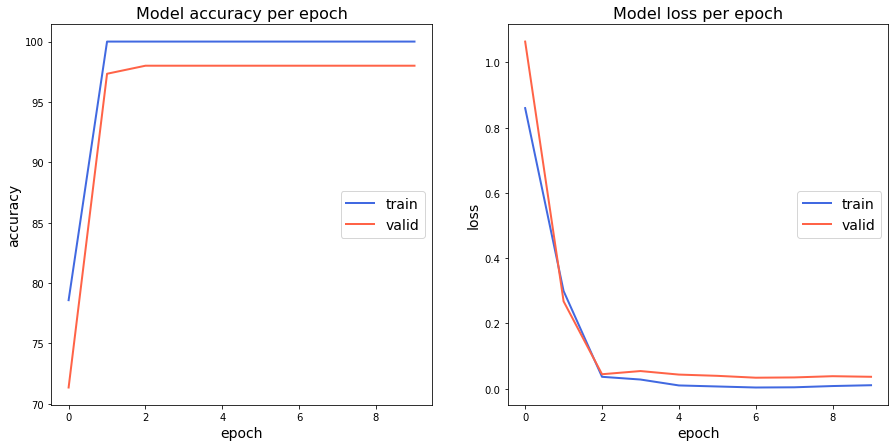

In [14]:
#Train and Valid Accuracy & Loss curve
#-------------------------------------------------------------------------------
print('\033[1m Accuracy for train dataset:{:.2f}%\033[0m'.format(List_acc_train[-1]))
print('\033[1m Accuracy for valid dataset:{:.2f}%\033[0m'.format(List_acc_valid[-1]))
print('\n')

#Accuracy curves
#-------------------------------------------------------------------------------
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(List_acc_train,"royalblue",linewidth=2)
plt.plot(List_acc_valid,"tomato",linewidth=2)
plt.title('Model accuracy per epoch',fontsize=16)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train', 'valid'], loc='right',fontsize=14)

#Loss curves
#-------------------------------------------------------------------------------
plt.subplot(122)
plt.plot(List_loss_train,"royalblue",linewidth=2)
plt.plot(List_loss_valid,"tomato",linewidth=2)
plt.title('Model loss per epoch',fontsize=16)
plt.ylabel('loss',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train', 'valid'], loc='right',fontsize=14)
plt.show()

In [15]:
PATH = './plant3_Res18_full.pth'
torch.save(model, PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label :Rust(2)


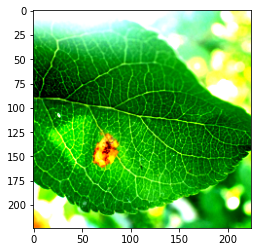

In [12]:
show_image(*train[1000])

In [22]:
transform_train = transforms.Compose([
    # 随机裁剪图像，所得图像为原始面积的0.08到1之间，高宽比在3/4和4/3之间。 
    # 然后，缩放图像以创建224 x 224的新图像
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    # 随机更改亮度，对比度和饱和度
    transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    # 添加随机噪声
    transforms.ToTensor(),
    # 标准化图像的每个通道
    transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])
transform_valid = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [25]:
batch_size = 64
train1 = ImageFolder(train_dir, transform=transform_train)
valid1 = ImageFolder(valid_dir, transform=transform_valid) 
train_dl1 = DataLoader(train1, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl1 = DataLoader(valid1, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label :Rust(2)


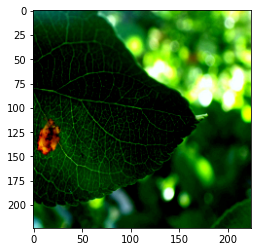

In [26]:
show_image(*train1[1000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label :Rust(2)


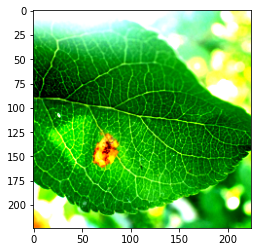

In [31]:
show_image(*train[1000])